# Two dimensional heatmap : scaling u and v

## Imports

In [30]:
import sys
import os
import os.path
import io
import csv
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import gamma
from scipy import integrate
import seaborn as sns
import numpy.random as nprand
from scipy.stats import gamma

In [31]:
init_path="../../../"

## Read files

In [32]:
def readfiles1(pathtofile, file_name, ext_name,withoutneutral,withoutnan,minq,minfert,logfert,line_to_begin):
    data_file = pathtofile+file_name+"."+ext_name
    data = dict()
    params = []
    nbline=1
    with io.open(data_file,'r') as f:
        reader = csv.reader(f)
        firstline = True
        for line in reader:
            lin = line[0].split()
            if not firstline:
                if nbline>=line_to_begin:
                    for j in range(len(lin)):
                        if ext_name == "allele":
                            if float(lin[5])>minq and float(lin[6])>minfert:
                                if withoutneutral==1 and float(lin[1]) != -3 :
                                    if withoutnan == 0:
                                        if logfert==True and (j==6 or j==9):
                                            data[params[j]].append(np.log(float(lin[j])))
                                        else:
                                            data[params[j]].append(float(lin[j]))
                                    elif withoutnan ==1 :
                                        if lin[5]!="-nan" and lin[6]!="-nan":
                                            if logfert==True and (j==6 or j==9):
                                                data[params[j]].append(np.log(float(lin[j])))
                                            else:
                                                data[params[j]].append(float(lin[j])) 
                                elif withoutneutral==0:
                                    if withoutnan == 0:
                                        if logfert==True and (j==6 or j==9):
                                            data[params[j]].append(np.log(float(lin[j])))
                                        else:
                                            data[params[j]].append(float(lin[j]))
                                    elif withoutnan ==1 :
                                        if lin[5]!="-nan" and lin[6]!="-nan":
                                            if logfert==True and (j==6 or j==9):
                                                data[params[j]].append(np.log(float(lin[j])))
                                            else:
                                                data[params[j]].append(float(lin[j]))
                        elif ext_name == "trace" and logfert==True and (j==6 or j==14):
                            data[params[j]].append(np.log(float(lin[j])))
                        else :
                            data[params[j]].append(float(lin[j]))
                nbline=nbline+1
            else:
                for j in lin:
                    data[j]=[]
                    params.append(j)
                firstline = False
                nbline=nbline+1
    return (data)

In [33]:
def readparamsfile(pathtofile, file_name, ext_name):
    data_file = pathtofile+file_name+"."+ext_name
    data = dict()
    params = []
    with io.open(data_file,'r') as f:
        reader = csv.reader(f)
        for line in reader:
            lin = line[0].split()
            data[lin[0]]=[]
            data[lin[0]].append(float(lin[1]))
    return (data)

## General parameters

In [34]:
N=5000
h=400
d=6
coeff_gamma=0.6
c=1

## Useful functions

In [35]:
def dico_data(target_folder_path,x_params,y_params, file_ext, withneutral,withoutnan,withlog,initline):
    list_files = sorted(os.listdir(target_folder_path))
    dico_file = dict()
    list_namefile=[]
    for file_name in list_files :
        if file_name.split(".")[1]==file_ext :
            if withneutral==1:
                data_file=readfiles(target_folder_path, file_name.split(".")[0], file_name.split(".")[1],0,withoutnan)
            elif withneutral==0:
                data_file=readfiles1(target_folder_path, file_name.split(".")[0], file_name.split(".")[1],1,withoutnan,0,0,withlog,initline)
            if  x_params in data_file and y_params in data_file :
                dico_file[(file_name.split(".")[0]).split("_")[-1]+"_x_params"]=data_file[x_params]
                dico_file[(file_name.split(".")[0]).split("_")[-1]+"_y_params"]=data_file[y_params]
            list_namefile.append((file_name.split(".")[0]).split("_")[2])
    list_namefile=sorted(list(set(list_namefile)))
    return (list_namefile,dico_file)

In [36]:
def simpson(f, a, b, n,coeff_gamma,c):
    pas = (b - a) / n
    somme = (f(a,coeff_gamma,c) + f(b,coeff_gamma,c)) / 2 + 2 * f(a + pas / 2,coeff_gamma,c)  # On initialise la somme
    x = a + pas           # La somme commence à x_1 
    for i in range(1, n): # On calcule la somme 
        somme += f(x,coeff_gamma,c) + 2 * f(x + pas / 2,coeff_gamma,c)
        x += pas
    return somme * pas / 3   # On retourne cette somme fois le pas / 3  


def gamma_func(aff,coeff_gamma):
    integral=1/coeff_gamma*np.exp(-aff*1/coeff_gamma)
    return integral

def x_0_func(aff,coeff_gamma,c):
    integral=(c*aff)/(1+c*aff)*gamma_func(aff,coeff_gamma)
    return integral
def x2_0_func(aff,coeff_gamma,c):
    integral=((c*aff)/(1+c*aff))**2*gamma_func(aff,coeff_gamma)
    return integral
def x3_0_func(aff,coeff_gamma,c):
    integral=((c*aff)/(1+c*aff))**3*gamma_func(aff,coeff_gamma)
    return integral
def x4_0_func(aff,coeff_gamma,c):
    integral=((c*aff)/(1+c*aff))**4*gamma_func(aff,coeff_gamma)
    return integral

In [37]:
x_0=simpson(x_0_func, 0, 100, 1000,coeff_gamma,c)
x2_0=simpson(x2_0_func, 0, 100, 1000,coeff_gamma,c)
x3_0=simpson(x3_0_func, 0, 100, 1000,coeff_gamma,c)
x4_0=simpson(x4_0_func, 0, 100, 1000,coeff_gamma,c)
q_0=(2*x2_0-x3_0)/(x_0)
w_0=1-np.exp(-d*q_0)
beta_0=(-2*x3_0+x4_0+(2*x2_0**2)/(x_0)-(x3_0*x2_0)/(x_0))/(2*x_0**2)
alpha=abs((1/w_0)*d*beta_0*np.exp(-d*q_0))

In [38]:
def s0_def(list_namefile_age,dico_file_age,list_namefile_freq,dico_file_freq):
    S0=[]
    for i in list_namefile_age :
        fert_moy=0
        n=len(dico_file_age[i+"_x_params"])
        m=min(dico_file_age[i+"_x_params"])
        ntot=0
        for j in range(n):
            if dico_file_age[i+"_x_params"][j]==m and dico_file_age[i+"_y_params"][j]!=0:
                fert_moy+=dico_file_age[i+"_y_params"][j]
                ntot+=1
        fertility_new_all=fert_moy/ntot
        meanfert=0
        for j in range(len(dico_file_age[i+"_y_params"])):
            meanfert=meanfert+dico_file_freq[i+"_y_params"][j]*dico_file_freq[i+"_x_params"][j]
        fert_moy=np.log(fert_moy/ntot)-np.log(np.mean(dico_file_age[i+"_y_params"]))
        S0.append(fert_moy)
    return(S0)

In [39]:
def sigmatau_def(u,v,d,coeff_gamma,c,target_folder_path,file_name,sig):
    x_0=simpson(x_0_func, 0, 100, 1000,coeff_gamma,c)
    x2_0=simpson(x2_0_func, 0, 100, 1000,coeff_gamma,c)
    x3_0=simpson(x3_0_func, 0, 100, 1000,coeff_gamma,c)
    x4_0=simpson(x4_0_func, 0, 100, 1000,coeff_gamma,c)
    q_0=(2*x2_0-x3_0)/(x_0)
    w_0=1-np.exp(-d*q_0)
    beta_0=(-2*x3_0+x4_0+(2*x2_0**2)/(x_0)-(x3_0*x2_0)/(x_0))/(2*x_0**2)
    alpha=abs((1/w_0)*d*beta_0*np.exp(-d*q_0))
    rho=(N*v*d)/(2*h)
    mu=4*N*u
    z_bar=np.sqrt(rho/(mu*alpha))
    DTau=np.sqrt(mu/(rho*alpha))
    Tau=2*np.sqrt(1/(rho*mu*alpha))
    s0=alpha*z_bar/2
    if sig==1:
        sigma=float(readparamsfile(target_folder_path, file_name, 'params')['sigma_0'][0])
    else :
        sigma=float(readparamsfile(target_folder_path, file_name, 'params')['Sigma_0'][0])
    return(sigma*Tau,Tau,sigma,s0)

## Heatmap function

In [40]:
withoutneutral=0
logfert=0
key="Diversity"
key1="Mean_sigma"
key2="Activity"
key3="mean_affinity"
key4="Mean_Age"

init_line=100
d=6
coeff_gamma=0.6


target_folder_path_1=init_path+"analyses/scaling_bidim_U_V/scaling_bidim_1" #without dosage, without interdiction of 2 DSB
target_folder_path_3=init_path+"analyses/scaling_bidim_U_V/scaling_bidim_2" #with dosage, without interdiction of 2 DSB
sig_1=0
sig_2=1

#sig_1=1
#sig_2=0
c=1
def heatmap_Div(target_folder_path, key, logfert, withoutneutral, init_line,coeff_gamma,c,sig):
    list_dir = sorted(os.listdir(target_folder_path))
    
    data = dict()
    theta = dict()
    mean_z = dict()
    sigmatau = dict()
    fourNu = dict()
    sigdtau = dict()
    tau = dict()
    sig0 = dict()
    Ns0 = dict()
    fourNs0 = dict()
    sigma_z = dict()
    Div_analytic = dict()
    act_analytic = dict()
    q_analytic = dict()
    fert_analytic = dict()
    mean_affinity=dict()
    mean_erosion=dict()
    
    col_names=[]
    list_index=[]
    first_loop=0
    
    for dir_name in list_dir :
        print(dir_name)
        v=float(dir_name.split("_")[2])
        data[float(dir_name.split("_")[2])]=[]
        theta[float(dir_name.split("_")[2])]=[]
        mean_z[float(dir_name.split("_")[2])]=[]
        sigmatau[float(dir_name.split("_")[2])]=[]
        fourNu[float(dir_name.split("_")[2])]=[]
        sigdtau[float(dir_name.split("_")[2])] = []
        tau[float(dir_name.split("_")[2])] = []
        sig0[float(dir_name.split("_")[2])] = []
        Ns0[float(dir_name.split("_")[2])] = []
        sigma_z[float(dir_name.split("_")[2])] = []
        Div_analytic[float(dir_name.split("_")[2])] = []
        act_analytic[float(dir_name.split("_")[2])] = []
        q_analytic[float(dir_name.split("_")[2])] = []
        fert_analytic[float(dir_name.split("_")[2])] = []
        mean_affinity[float(dir_name.split("_")[2])]=[]
        mean_erosion[float(dir_name.split("_")[2])]=[]
        col_names.append(float((dir_name.split(".")[0]).split("_")[2]))
        
        list_files = sorted(os.listdir(target_folder_path+'/'+dir_name))
        
        list_namefile,dico_file=dico_data(target_folder_path+'/'+dir_name+'/',"Age","fertility_analytic","allele",0,1,False,0)
        list_namefile1,dico_file1=dico_data(target_folder_path+'/'+dir_name+'/',"Frequency","fertility_analytic","allele",0,1,False,0)
        
        s0_init=s0_def(list_namefile,dico_file,list_namefile1,dico_file1)
        for ind_s0 in range(len(s0_init)):
            s0_init[ind_s0]=s0_init[ind_s0]*4*N
            
        fourNs0[float(dir_name.split("_")[2])] = s0_def(list_namefile,dico_file,list_namefile1,dico_file1)
        for files_name in list_files :
            #print(files_name)
            if files_name.split(".")[1]=="trace":
                if first_loop==0:
                    list_index.append(float((files_name.split(".")[0]).split("_")[2]))
                u=float((files_name.split(".")[0]).split("_")[2])
                data_file = readfiles1(target_folder_path+'/'+dir_name+'/', files_name.split(".")[0], files_name.split(".")[1],withoutneutral,0,0,0,logfert,0)
                data[float(dir_name.split("_")[2])].append(np.mean(data_file[key][init_line:]))
                theta[float(dir_name.split("_")[2])].append(np.mean(data_file[key2][init_line:]))
                mean_erosion[float(dir_name.split("_")[2])].append(1-np.mean(data_file[key2][init_line:]))
                mean_z[float(dir_name.split("_")[2])].append(np.mean(data_file[key4][init_line:]))
                mu=4*N*u
                rho=N*v*d/(2*h)  
                z_bar=np.sqrt(rho/(mu*alpha))
                sigmatau[float(dir_name.split("_")[2])].append(sigmatau_def(float((files_name.split(".")[0]).split("_")[2]),float(dir_name.split("_")[2]),d,coeff_gamma,c,target_folder_path+'/'+dir_name+'/',files_name.split(".")[0],sig)[0])
                fourNu[float(dir_name.split("_")[2])].append(4*N*float((files_name.split(".")[0]).split("_")[2]))
                sigdtau[float(dir_name.split("_")[2])].append(sigmatau_def(float((files_name.split(".")[0]).split("_")[2]),float(dir_name.split("_")[2]),d,coeff_gamma,c,target_folder_path+'/'+dir_name+'/',files_name.split(".")[0],sig)[0]*np.mean(data_file[key][init_line:]))
                tau[float(dir_name.split("_")[2])].append(sigmatau_def(float((files_name.split(".")[0]).split("_")[2]),float(dir_name.split("_")[2]),d,coeff_gamma,c,target_folder_path+'/'+dir_name+'/',files_name.split(".")[0],sig)[1])
                sig0[float(dir_name.split("_")[2])].append(sigmatau_def(float((files_name.split(".")[0]).split("_")[2]),float(dir_name.split("_")[2]),d,coeff_gamma,c,target_folder_path+'/'+dir_name+'/',files_name.split(".")[0],sig)[2])
                Ns0[float(dir_name.split("_")[2])].append(sigmatau_def(float((files_name.split(".")[0]).split("_")[2]),float(dir_name.split("_")[2]),d,coeff_gamma,c,target_folder_path+'/'+dir_name+'/',files_name.split(".")[0],sig)[2]*N)
                Div_analytic[float(dir_name.split("_")[2])].append(24*N*float((files_name.split(".")[0]).split("_")[2]))
                act_analytic[float(dir_name.split("_")[2])].append(np.exp(-np.sqrt(v*d/(8*h*alpha*u))))
                if sig==1 :
                    sigma_z[float(dir_name.split("_")[2])].append(np.mean(data_file[key1][init_line:]))
            if files_name.split(".")[1]=="allele":
                data_file = readfiles1(target_folder_path+'/'+dir_name+'/', files_name.split(".")[0], files_name.split(".")[1],withoutneutral,0,0,0,logfert,0)
                mean_affinity[float(dir_name.split("_")[2])].append((np.mean(data_file[key3][init_line:])))
        first_loop=1
    return (data,col_names,list_index,sigmatau,fourNu,sigdtau,tau,sig0,Ns0,fourNs0,sigma_z,Div_analytic,act_analytic,q_analytic,fert_analytic,mean_affinity,theta,mean_z,mean_erosion)

## Data storage

In [41]:
target_folder_path_1=init_path+"analyses/scaling_bidim_U_V/scaling_bidim_1" # without dosage
(data_1,col_names_1,list_index_1,sigmatau_1,fourNu_1,sigdtau_1,tau_1,sig0_1,Ns0_1,fourNs0_1,sigma_z_1,Div_analytic_1,act_analytic_1,q_analytic_1,fert_analytic_1,mean_affinity_1,theta_1,mean_z_1,mean_erosion_1)=heatmap_Div(target_folder_path_1, key, logfert, withoutneutral, init_line,coeff_gamma,c,sig_1)

scaling_V_2e-3
scaling_V_2e-4
scaling_V_2e-5
scaling_V_2e-6
scaling_V_5e-3
scaling_V_5e-4
scaling_V_5e-5
scaling_V_5e-6


In [42]:
target_folder_path_3=init_path+"analyses/scaling_bidim_U_V/scaling_bidim_2" # with dosage
(data_3,col_names_3,list_index_3,sigmatau_3,fourNu_3,sigdtau_3,tau_3,sig0_3,Ns0_3,fourNs0_3,sigma_z_3,Div_analytic_3,act_analytic_3,q_analytic_3,fert_analytic_3,mean_affinity_3,theta_3,mean_z_3,mean_erosion_3)=heatmap_Div(target_folder_path_3, key, logfert, withoutneutral, init_line,coeff_gamma,c,sig_1)

scaling_V_2e-3
scaling_V_2e-4
scaling_V_2e-5
scaling_V_2e-6
scaling_V_5e-3
scaling_V_5e-4
scaling_V_5e-5
scaling_V_5e-6


## Heatmaps

### Summary of previous heatmap in one figure

<Figure size 640x480 with 0 Axes>

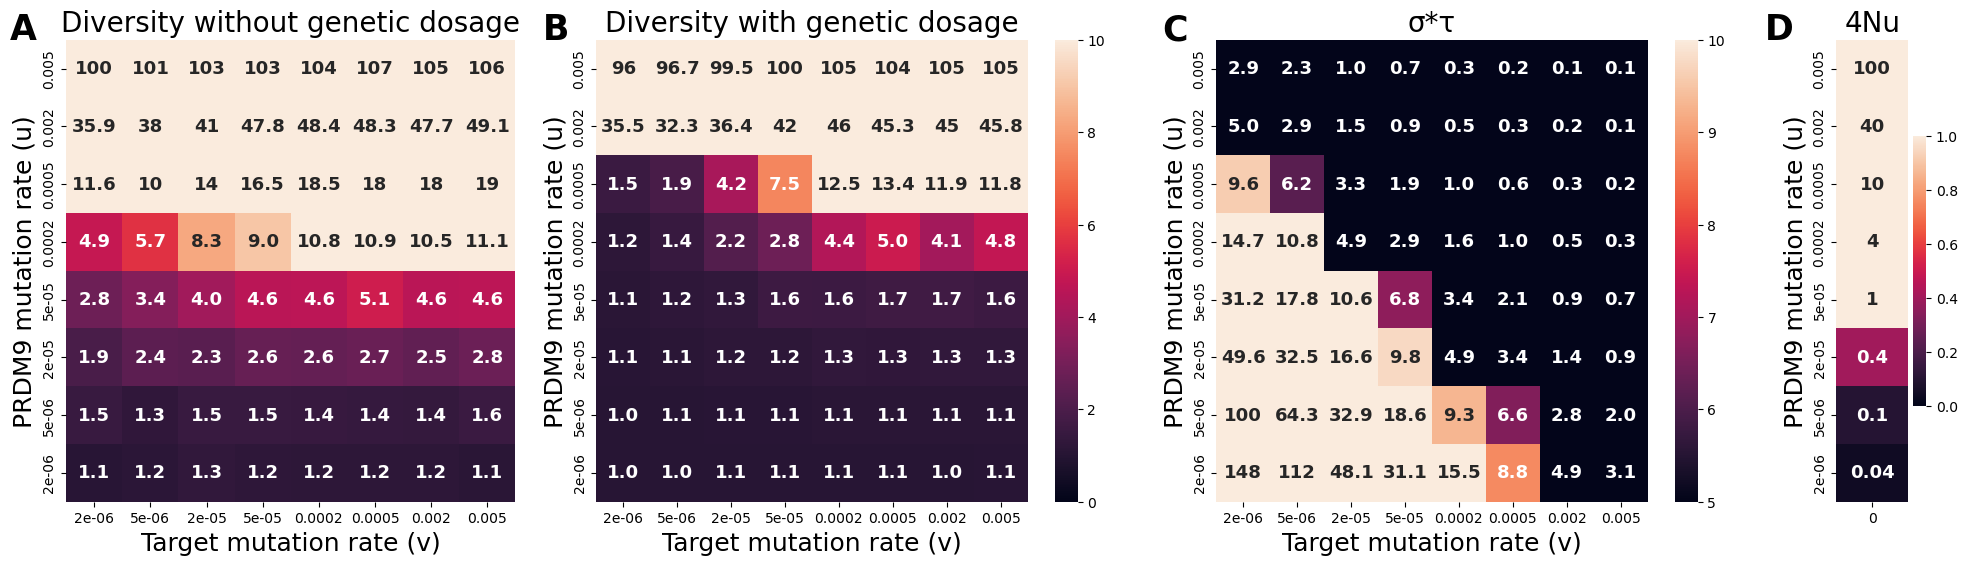

In [28]:
df_1 = pd.DataFrame(data_1, index = list_index_1)
df_1=df_1.sort_index(axis = 0,ascending = False)
df_1=df_1.sort_index(axis = 1,ascending = True)

df_3 = pd.DataFrame(data_3, index = list_index_3)
df_3=df_3.sort_index(axis = 0,ascending = False)
df_3=df_3.sort_index(axis = 1,ascending = True)

df_sigmatau_1 = pd.DataFrame(sigmatau_1, index = list_index_1)
df_sigmatau_1=df_sigmatau_1.sort_index(axis = 0,ascending = False)
df_sigmatau_1=df_sigmatau_1.sort_index(axis = 1,ascending = True)

fourNu_col=[]
list_index_1_bis=sorted(list_index_1)
for i in range(len(list_index_1_bis)):
    fourNu_col.append(4*N*list_index_1_bis[i])
df_fourNu_col = pd.DataFrame(fourNu_col, index = list_index_1_bis)
df_fourNu_col=df_fourNu_col.sort_index(axis = 0,ascending = False)

figure=plt.figure()
figure, axs = plt.subplots(ncols=4, gridspec_kw=dict(width_ratios=[5,6,6,1]),figsize=(24,6))
figure.patch.set_facecolor('white')
figure.patch.set_alpha(0)

sns.heatmap(df_1, annot=True, cbar=False, ax=axs[0], vmin=0, vmax=10, mask=df_1 >= 10, annot_kws={"weight": "bold",'size': 13}, fmt='2.1f')
sns.heatmap(df_1, annot=True, cbar=False, ax=axs[0], vmin=0, vmax=10, mask=df_1 < 10, annot_kws={"weight": "bold",'size': 13}, fmt='.3g')
sns.heatmap(df_3, annot=True, cbar=False, ax=axs[1], vmin=0, vmax=10, mask=df_3 >= 10, annot_kws={"weight": "bold",'size': 13}, fmt='2.1f')
sns.heatmap(df_3, annot=True, ax=axs[1], vmin=0, vmax=10, mask=df_3 < 10, annot_kws={"weight": "bold",'size': 13}, fmt='.3g')
sns.heatmap(df_sigmatau_1,ax=axs[2], cbar=False ,annot=True,vmin=5,vmax=10, mask=df_sigmatau_1 >= 10, annot_kws={"weight": "bold",'size': 13}, fmt='2.1f')
sns.heatmap(df_sigmatau_1,ax=axs[2],annot=True,vmin=5,vmax=10, mask=df_sigmatau_1 < 10, annot_kws={"weight": "bold",'size': 13}, fmt='.3g')
sns.heatmap(df_fourNu_col,ax=axs[3],annot=True,vmin=0,vmax=1, annot_kws={"weight": "bold",'size': 13}, fmt='.3g')

axs[0].set_ylabel('PRDM9 mutation rate (u)',size=18)
axs[0].set_xlabel('Target mutation rate (v)',size=18)
axs[1].set_ylabel('PRDM9 mutation rate (u)',size=18)
axs[1].set_xlabel('Target mutation rate (v)',size=18)
axs[2].set_ylabel('PRDM9 mutation rate (u)',size=18)
axs[2].set_xlabel('Target mutation rate (v)',size=18)
axs[3].set_ylabel('PRDM9 mutation rate (u)',size=18)


axs[0].set_title("Diversity without genetic dosage",size=20)
axs[1].set_title("Diversity with genetic dosage",size=20)
axs[2].set_title("σ*τ",size=20)
axs[3].set_title("4Nu",size=20)

axs[0].text(y=0,x=-1,s="A",fontsize=25,fontweight='bold')
axs[1].text(y=0,x=-1,s="B",fontsize=25,fontweight='bold')
axs[2].text(y=0,x=-1,s="C",fontsize=25,fontweight='bold')
axs[3].text(y=0,x=-1,s="D",fontsize=25,fontweight='bold')

plt.show()

**Caption : Change of regime between without and with genetic dosage according to mutation rates
of PRDM9 u and targets v.** Diversity without (A) and with (B) genetic dosage. (C) Selection coefficient
associated to dosage (σ ) times the time between two allele invasion (τ). (D) 4Nu for each u

## Fig 6

<Figure size 640x480 with 0 Axes>

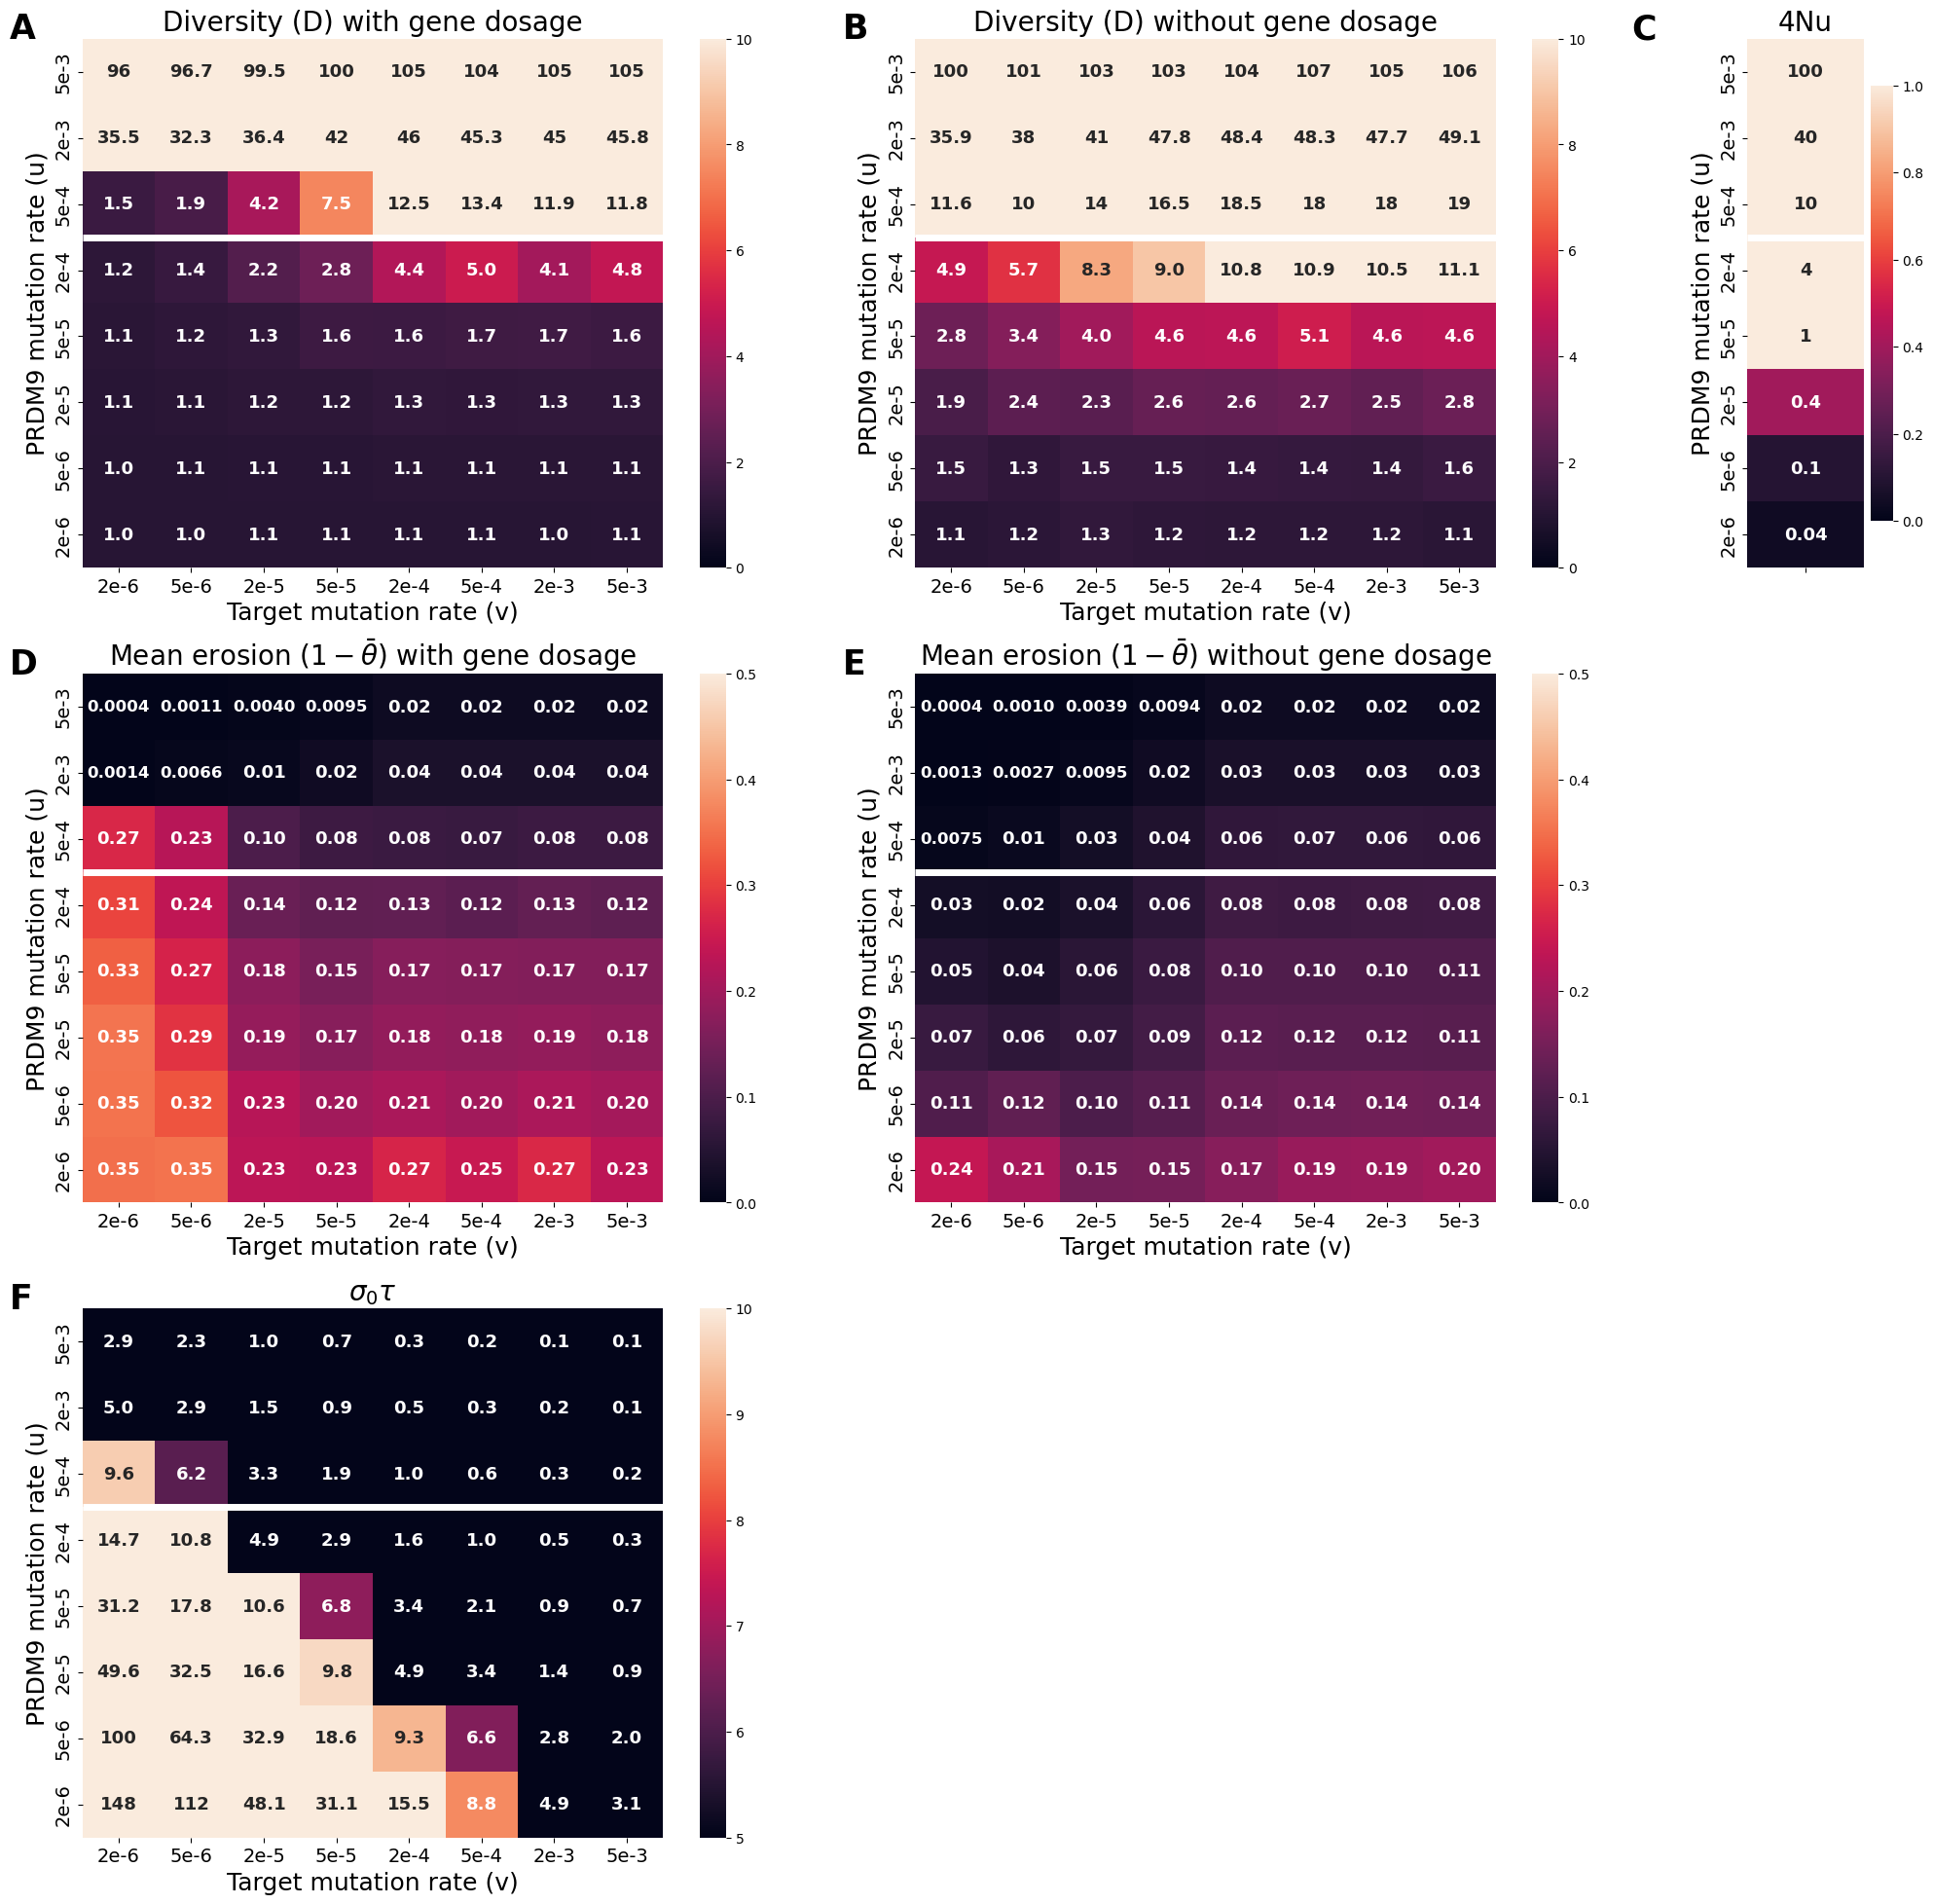

In [45]:
df_1 = pd.DataFrame(data_1, index = list_index_1)
df_1=df_1.sort_index(axis = 0,ascending = False)
df_1=df_1.sort_index(axis = 1,ascending = True)

df_3 = pd.DataFrame(data_3, index = list_index_3)
df_3=df_3.sort_index(axis = 0,ascending = False)
df_3=df_3.sort_index(axis = 1,ascending = True)

df_sigmatau_1 = pd.DataFrame(sigmatau_1, index = list_index_1)
df_sigmatau_1=df_sigmatau_1.sort_index(axis = 0,ascending = False)
df_sigmatau_1=df_sigmatau_1.sort_index(axis = 1,ascending = True)

df_mean_erosion_2 = pd.DataFrame(mean_erosion_3, index = list_index_3)
df_mean_erosion_2=df_mean_erosion_2.sort_index(axis = 0,ascending = False)
df_mean_erosion_2=df_mean_erosion_2.sort_index(axis = 1,ascending = True)

df_mean_erosion_1 = pd.DataFrame(mean_erosion_1, index = list_index_1)
df_mean_erosion_1=df_mean_erosion_1.sort_index(axis = 0,ascending = False)
df_mean_erosion_1=df_mean_erosion_1.sort_index(axis = 1,ascending = True)

fourNu_col=[]
list_index_1_bis=sorted(list_index_1)
for i in range(len(list_index_1_bis)):
    fourNu_col.append(4*N*list_index_1_bis[i])
df_fourNu_col = pd.DataFrame(fourNu_col, index = list_index_1_bis)
df_fourNu_col=df_fourNu_col.sort_index(axis = 0,ascending = False)




figure=plt.figure()
figure, axs = plt.subplots(ncols=3,nrows=3, gridspec_kw=dict(width_ratios=[5,5,1],height_ratios=[5,5,5]),figsize=(24,24))
figure.patch.set_facecolor('white')
figure.patch.set_alpha(0)

sns.heatmap(df_1, annot=True, cbar=False, ax=axs[0,1], vmin=0, vmax=10, mask=df_1 >= 10, annot_kws={"weight": "bold",'size': 13}, fmt='2.1f')
sns.heatmap(df_1, annot=True, ax=axs[0,1], vmin=0, vmax=10, mask=df_1 < 10, annot_kws={"weight": "bold",'size': 13}, fmt='.3g')
sns.heatmap(df_mean_erosion_2, annot=True, cbar=False, ax=axs[1,0], vmin=0, vmax=0.5, mask=df_mean_erosion_2 >= 0.01, annot_kws={"weight": "bold",'size': 12}, fmt='2.4f')
sns.heatmap(df_mean_erosion_2, annot=True, ax=axs[1,0], vmin=0, vmax=0.5, mask=df_mean_erosion_2 < 0.01, annot_kws={"weight": "bold",'size': 13}, fmt='2.2f')
#sns.heatmap(df_mean_erosion_2,ax=axs[0,1],annot=True,vmin=0,vmax=1, annot_kws={"weight": "bold",'size': 13}, fmt='2.2f')
sns.heatmap(df_3, annot=True, cbar=False, ax=axs[0,0], vmin=0, vmax=10, mask=df_3 >= 10, annot_kws={"weight": "bold",'size': 13}, fmt='2.1f')
sns.heatmap(df_3, annot=True, ax=axs[0,0], vmin=0, vmax=10, mask=df_3 < 10, annot_kws={"weight": "bold",'size': 13}, fmt='.3g')
sns.heatmap(df_sigmatau_1,ax=axs[2,0], cbar=False ,annot=True,vmin=5,vmax=10, mask=df_sigmatau_1 >= 10, annot_kws={"weight": "bold",'size': 13}, fmt='2.1f')
sns.heatmap(df_sigmatau_1,ax=axs[2,0],annot=True,vmin=5,vmax=10, mask=df_sigmatau_1 < 10, annot_kws={"weight": "bold",'size': 13}, fmt='.3g')
sns.heatmap(df_fourNu_col,ax=axs[0,2],annot=True,vmin=0,vmax=1, annot_kws={"weight": "bold",'size': 13}, fmt='.3g')
sns.heatmap(df_mean_erosion_1, annot=True, cbar=False, ax=axs[1,1], vmin=0, vmax=0.5, mask=df_mean_erosion_1 >= 0.01, annot_kws={"weight": "bold",'size': 12}, fmt='2.4f')
sns.heatmap(df_mean_erosion_1, annot=True, ax=axs[1,1], vmin=0, vmax=0.5, mask=df_mean_erosion_1 < 0.01, annot_kws={"weight": "bold",'size': 13}, fmt='2.2f')
figure.delaxes(axs[1,2])  # delete the empty subplot
figure.delaxes(axs[2,1])
figure.delaxes(axs[2,2])

axs[0,0].hlines(3, *axs[0,0].get_xlim(),colors="white",linewidth=5)
axs[0,1].hlines(3, *axs[0,0].get_xlim(),colors="white",linewidth=5)
axs[0,2].hlines(3, *axs[0,0].get_xlim(),colors="white",linewidth=5)
axs[1,0].hlines(3, *axs[0,0].get_xlim(),colors="white",linewidth=5)
axs[1,1].hlines(3, *axs[0,0].get_xlim(),colors="white",linewidth=5)
axs[2,0].hlines(3, *axs[0,0].get_xlim(),colors="white",linewidth=5)

axs[0,0].set_ylabel('PRDM9 mutation rate (u)',size=18)
axs[0,0].set_xlabel('Target mutation rate (v)',size=18)
axs[0,1].set_ylabel('PRDM9 mutation rate (u)',size=18)
axs[0,1].set_xlabel('Target mutation rate (v)',size=18)
axs[1,0].set_ylabel('PRDM9 mutation rate (u)',size=18)
axs[1,0].set_xlabel('Target mutation rate (v)',size=18)
axs[1,1].set_ylabel('PRDM9 mutation rate (u)',size=18)
axs[1,1].set_xlabel('Target mutation rate (v)',size=18)
axs[0,2].set_ylabel('PRDM9 mutation rate (u)',size=18)
axs[2,0].set_ylabel('PRDM9 mutation rate (u)',size=18)
axs[2,0].set_xlabel('Target mutation rate (v)',size=18)

#axs[0,0].tick_params(axis = 'both', labelsize = 14)
x_labels=["2e-6","5e-6","2e-5","5e-5","2e-4","5e-4","2e-3","5e-3"]
y_labels=["5e-3","2e-3","5e-4","2e-4","5e-5","2e-5","5e-6","2e-6"]
axs[0,0].xaxis.set_ticklabels(x_labels,fontsize=14)
axs[0,0].yaxis.set_ticklabels(y_labels,fontsize=14)
axs[0,1].xaxis.set_ticklabels(x_labels,fontsize=14)
axs[0,1].yaxis.set_ticklabels(y_labels,fontsize=14)
axs[0,2].yaxis.set_ticklabels(y_labels,fontsize=14)
axs[0,2].xaxis.set_tick_params(labelbottom=False)
axs[1,0].xaxis.set_ticklabels(x_labels,fontsize=14)
axs[1,0].yaxis.set_ticklabels(y_labels,fontsize=14)
axs[1,1].xaxis.set_ticklabels(x_labels,fontsize=14)
axs[1,1].yaxis.set_ticklabels(y_labels,fontsize=14)
axs[2,0].xaxis.set_ticklabels(x_labels,fontsize=14)
axs[2,0].yaxis.set_ticklabels(y_labels,fontsize=14)

axs[0,1].set_title("Diversity (D) without gene dosage",size=20)
axs[1,0].set_title("Mean erosion ("r"$1-\bar \theta$) with gene dosage",size=20)
axs[1,1].set_title("Mean erosion ("r"$1-\bar \theta$) without gene dosage",size=20)
axs[0,0].set_title("Diversity (D) with gene dosage",size=20)
axs[2,0].set_title(""r"$\sigma_0 \tau$",size=20)#σ0τ
axs[0,2].set_title("4Nu",size=20)

axs[0,0].text(y=0,x=-1,s="A",fontsize=25,fontweight='bold')
axs[0,1].text(y=0,x=-1,s="B",fontsize=25,fontweight='bold')
axs[0,2].text(y=0,x=-1,s="C",fontsize=25,fontweight='bold')
axs[1,0].text(y=0,x=-1,s="D",fontsize=25,fontweight='bold')
axs[1,1].text(y=0,x=-1,s="E",fontsize=25,fontweight='bold')
axs[2,0].text(y=0,x=-1,s="F",fontsize=25,fontweight='bold')

plt.show()